# Named Entity Recognition (NER) in Natural Language Processing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/nlp-learning-journey/blob/main/examples/ner.ipynb)

## Overview

Named Entity Recognition (NER) is the task of identifying and classifying named entities in text into predefined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

## What You'll Learn

- Understanding different types of named entities
- Using NLTK for basic NER
- Advanced NER with spaCy
- Custom entity recognition
- Transformer-based NER models
- Evaluation metrics for NER
- Real-world applications

## Prerequisites

Basic understanding of Python, NLP concepts, and tokenization.

## Setup and Installation

In [16]:
# Environment Detection and Setup
import sys
import subprocess

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\nSetting up Google Colab environment...")
    !apt update -qq
    !apt install -y -qq libpq-dev
elif IS_KAGGLE:
    print("\nSetting up Kaggle environment...")
    # Kaggle usually has most packages pre-installed
else:
    print("\nSetting up local environment...")

# Install required packages for this notebook
required_packages = [
    "nltk",
    "spacy",
    "pandas",
    "matplotlib",
    "seaborn",
    "transformers"
]

print("\nInstalling required packages...")
for package in required_packages:
    if IS_COLAB or IS_KAGGLE:
        !pip install -q {package}
    else:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                      capture_output=True)
    print(f"✓ {package}")

# Download spaCy model
print("\nDownloading spaCy English model...")
try:
    if IS_COLAB or IS_KAGGLE:
        !python -m spacy download en_core_web_sm
    else:
        subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"],
                      capture_output=True)
    print("✓ spaCy model downloaded successfully")
except Exception as e:
    print(f"⚠️  spaCy model download failed: {e}")

print("\n🎉 Environment setup complete!")

Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

Setting up Google Colab environment...
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
libpq-dev is already the newest version (14.19-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

Installing required packages...
✓ nltk
✓ spacy
✓ pandas
✓ matplotlib
✓ seaborn
✓ transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Res

In [17]:
# Import required libraries
import nltk
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

# Download NLTK data with error handling
nltk_datasets = ['punkt', 'punkt_tab', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng',
                 'maxent_ne_chunker', 'maxent_ne_chunker_tab', 'words']
print("Downloading NLTK datasets...")
for dataset in nltk_datasets:
    try:
        nltk.download(dataset, quiet=True)
        print(f"✓ {dataset}")
    except Exception as e:
        print(f"⚠️  Failed to download {dataset}: {e}")

# Import NLTK modules
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.tree import Tree

# Load spaCy model with error handling
try:
    nlp = spacy.load('en_core_web_sm')
    print("✓ spaCy model loaded successfully")
except OSError:
    print("⚠️  spaCy model not found. Please run the setup cell above.")
    nlp = None

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

✓ punkt
✓ punkt_tab
✓ averaged_perceptron_tagger
✓ averaged_perceptron_tagger_eng
✓ maxent_ne_chunker
✓ maxent_ne_chunker_tab
✓ words
✓ spaCy model loaded successfully


## Understanding Named Entities

Common entity types include:
- PERSON: People, including fictional characters
- ORGANIZATION: Companies, agencies, institutions
- LOCATION: Countries, cities, states
- DATE: Dates and time expressions
- MONEY: Monetary values
- PERCENT: Percentage values

In [18]:
# Sample text for NER demonstration
sample_text = """
Australian politicians rally behind ABC journalist after clash with Donald Trump. Australia’s politicians have thrown their support behind an ABC journalist who was berated by Donald Trump after asking questions about the US president’s personal business dealings in Washington DC on Tuesday.
Trump was answering questions on the White House lawn when he clashed with the ABC’s Americas editor, John Lyons, who said he was reporting for Four Corners.
"""

print("Sample text:")
print(sample_text.strip())

Sample text:
Australian politicians rally behind ABC journalist after clash with Donald Trump. Australia’s politicians have thrown their support behind an ABC journalist who was berated by Donald Trump after asking questions about the US president’s personal business dealings in Washington DC on Tuesday.
Trump was answering questions on the White House lawn when he clashed with the ABC’s Americas editor, John Lyons, who said he was reporting for Four Corners.


## NLTK Named Entity Recognition

In [19]:
def extract_entities_nltk(text):
    """Extract named entities using NLTK"""
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    chunks = ne_chunk(pos_tags)

    entities = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            entity_text = ' '.join([token for token, pos in chunk.leaves()])
            entity_label = chunk.label()
            entities.append((entity_text, entity_label))

    return entities

# Test NLTK NER
nltk_entities = extract_entities_nltk(sample_text)
print("NLTK NER Results:")
for entity, label in nltk_entities:
    print(f"  {entity:20} -> {label}")

NLTK NER Results:
  Australian           -> GPE
  ABC                  -> ORGANIZATION
  Donald Trump         -> PERSON
  Australia            -> PERSON
  ABC                  -> ORGANIZATION
  Donald Trump         -> PERSON
  US                   -> GSP
  Washington           -> GPE
  Trump                -> PERSON
  White House          -> FACILITY
  ABC                  -> ORGANIZATION
  Americas             -> GPE
  John Lyons           -> PERSON
  Four Corners         -> ORGANIZATION


## spaCy Named Entity Recognition

In [20]:
def extract_entities_spacy(text):
    """Extract named entities using spaCy"""
    doc = nlp(text)

    entities = []
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char,
            'description': spacy.explain(ent.label_)
        })

    return entities

# Test spaCy NER
spacy_entities = extract_entities_spacy(sample_text)
print("spaCy NER Results:")
print(f"{'Entity':<20} {'Label':<10} {'Description':<30}")
print("-" * 65)
for ent in spacy_entities:
    print(f"{ent['text']:<20} {ent['label']:<10} {ent['description']:<30}")

spaCy NER Results:
Entity               Label      Description                   
-----------------------------------------------------------------
Australian           NORP       Nationalities or religious or political groups
ABC                  ORG        Companies, agencies, institutions, etc.
Donald Trump         PERSON     People, including fictional   
Australia            GPE        Countries, cities, states     
ABC                  ORG        Companies, agencies, institutions, etc.
Donald Trump         PERSON     People, including fictional   
US                   GPE        Countries, cities, states     
Washington DC        GPE        Countries, cities, states     
Tuesday              DATE       Absolute or relative dates or periods
Trump                PERSON     People, including fictional   
the White House      ORG        Companies, agencies, institutions, etc.
ABC’s Americas       ORG        Companies, agencies, institutions, etc.
John Lyons           PERSON     Peopl

## Entity Visualization and Analysis

Entity Type Distribution:
  ORG: 6
  PERSON: 5
  GPE: 5
  DATE: 2
  NORP: 1
  TIME: 1
  MONEY: 1


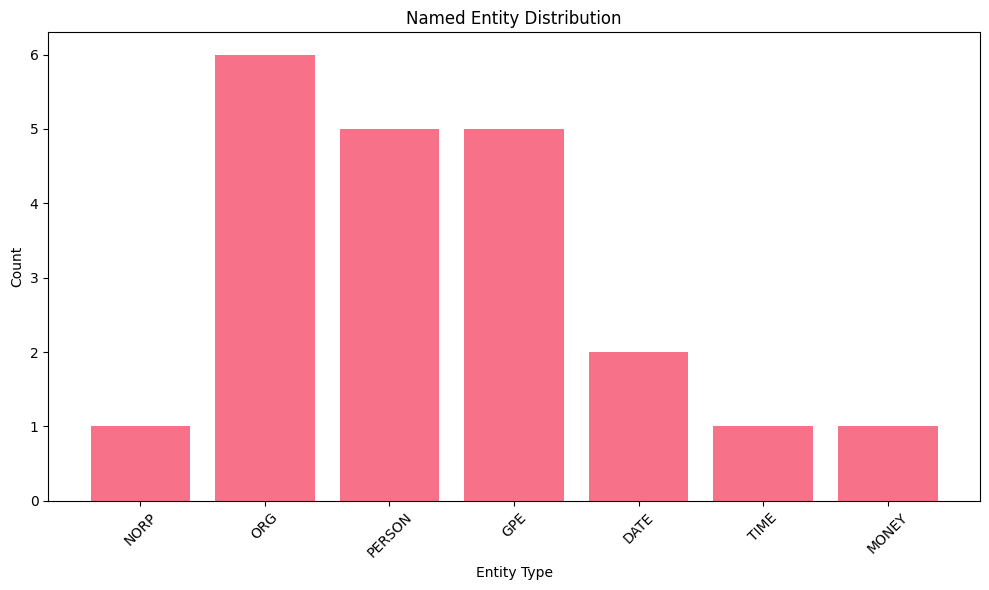

In [21]:
# Analyze entity distribution
def analyze_entities(texts):
    """Analyze entity distribution across multiple texts"""
    all_entities = []

    for text in texts:
        entities = extract_entities_spacy(text)
        all_entities.extend(entities)

    # Count entity types
    entity_counts = Counter([ent['label'] for ent in all_entities])

    return entity_counts, all_entities

# Example texts
example_texts = [
    sample_text,
    "Microsoft reported strong earnings. CEO Satya Nadella praised the team's performance in Seattle.",
    "The meeting is scheduled for January 15, 2024, at 2:30 PM in New York. Budget allocation is $2.5 million."
]

entity_counts, all_entities = analyze_entities(example_texts)

print("Entity Type Distribution:")
for entity_type, count in entity_counts.most_common():
    print(f"  {entity_type}: {count}")

# Create visualization
plt.figure(figsize=(10, 6))
entity_types = list(entity_counts.keys())
counts = list(entity_counts.values())

plt.bar(entity_types, counts)
plt.title('Named Entity Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Custom Entity Recognition

In [22]:
def custom_entity_recognizer(text):
    """Custom entity recognizer for domain-specific entities"""
    entities = []

    # Custom patterns
    patterns = {
        'EMAIL': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'PHONE': r'\b(?:\+?1[-.]?)?\(?([0-9]{3})\)?[-.]?([0-9]{3})[-.]?([0-9]{4})\b',
        'URL': r'https?://[^\s]+',
        'PRODUCT_CODE': r'\b[A-Z]{2,3}-\d{3,6}\b',
        'VERSION': r'\bv?\d+\.\d+(?:\.\d+)?\b'
    }

    for entity_type, pattern in patterns.items():
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            entities.append({
                'text': match.group(),
                'label': entity_type,
                'start': match.start(),
                'end': match.end()
            })

    return entities

# Test custom NER
custom_text = """
Contact support at help@company.com or call (555) 123-4567.
Visit https://example.com for product ABC-12345 version 2.1.0.
"""

custom_entities = custom_entity_recognizer(custom_text)
print("Custom NER Results:")
for ent in custom_entities:
    print(f"  {ent['text']:20} -> {ent['label']}")

Custom NER Results:
  help@company.com     -> EMAIL
  https://example.com  -> URL
  ABC-12345            -> PRODUCT_CODE
  2.1.0                -> VERSION


## Real-World Applications

In [23]:
# Application 1: Information Extraction
def extract_key_info(text):
    """Extract key information from text"""
    entities = extract_entities_spacy(text)

    info = {
        'people': [ent['text'] for ent in entities if ent['label'] == 'PERSON'],
        'organizations': [ent['text'] for ent in entities if ent['label'] == 'ORG'],
        'locations': [ent['text'] for ent in entities if ent['label'] in ['GPE', 'LOC']],
        'dates': [ent['text'] for ent in entities if ent['label'] == 'DATE'],
        'money': [ent['text'] for ent in entities if ent['label'] == 'MONEY']
    }

    return info

# Application 2: Privacy Protection
def mask_sensitive_entities(text):
    """Mask sensitive information in text"""
    entities = extract_entities_spacy(text)
    custom_entities = custom_entity_recognizer(text)

    # Combine entities
    all_entities = entities + custom_entities

    # Sort by start position (reverse order for replacement)
    all_entities.sort(key=lambda x: x['start'], reverse=True)

    masked_text = text
    sensitive_types = ['PERSON', 'EMAIL', 'PHONE']

    for ent in all_entities:
        if ent['label'] in sensitive_types:
            mask = f"[{ent['label']}]"
            masked_text = masked_text[:ent['start']] + mask + masked_text[ent['end']:]

    return masked_text

# Test applications
news_text = """
Apple CEO Tim Cook announced record quarterly earnings of $89.5 billion
during a conference call yesterday from Cupertino, California.
"""

print("Information Extraction:")
info = extract_key_info(news_text)
for category, items in info.items():
    if items:
        print(f"  {category.title()}: {items}")

sensitive_text = """
Please contact John Smith at john.smith@email.com or call (555) 123-4567
regarding the urgent matter.
"""

print("\nPrivacy Protection:")
print(f"Original: {sensitive_text.strip()}")
print(f"Masked: {mask_sensitive_entities(sensitive_text).strip()}")

Information Extraction:
  People: ['Tim Cook']
  Organizations: ['Apple']
  Locations: ['Cupertino', 'California']
  Dates: ['quarterly', 'yesterday']
  Money: ['$89.5 billion']

Privacy Protection:
Original: Please contact John Smith at john.smith@email.com or call (555) 123-4567 
regarding the urgent matter.
Masked: Please contact [PERSON] at [EMAIL] or call (555) 123-4567 
regarding the urgent matter.


## Exercises

1. **Domain-Specific NER**: Create a custom NER system for medical, legal, or financial text
2. **Entity Linking**: Connect identified entities to a knowledge base
3. **Multilingual NER**: Handle entities in multiple languages
4. **Entity Resolution**: Identify when different mentions refer to the same entity

## Key Takeaways

- NER is essential for information extraction and text understanding
- spaCy provides production-ready NER with high accuracy
- Custom patterns can handle domain-specific entities
- Combining multiple approaches often yields better results
- Consider privacy implications when processing personal data

## Next Steps

- Learn about relationship extraction
- Explore entity linking and knowledge graphs
- Study coreference resolution
- Practice with domain-specific datasets

## Resources

- [spaCy NER Documentation](https://spacy.io/usage/linguistic-features#named-entities)
- [NLTK Named Entity Recognition](https://www.nltk.org/book/ch07.html)
- [CoNLL-2003 NER Dataset](https://www.clips.uantwerpen.be/conll2003/ner/)
- [OntoNotes 5.0](https://catalog.ldc.upenn.edu/LDC2013T19)